# ACUTE INFRACT LOCATION DETECTION USING CNN

## Deep learning with hardware acceleration 

## Final project

**About the dataset:**<br>

The dataset contains 50 cases of patients having the acute infract in the folder and a pdf which maps the cases with the location of disease in brain.

Each case has 3 image : DWI.jpg , FLAIR.jpg , ADC.jpg

Out of these three images DWI is most relevent to Acute Infract.

# TOPICS
    - data augmentation
    - load dataset
    - dataset preprocessing
    - build the model
    - loss=categorical_crossentropy 
    - softmax activation function
    - optimizer = adam  (extension of stocastic gradient descent)
    - converting into .pb file

## Import Necessary Modules

In [53]:
#!pip install imutils
#!pip install sklearn

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential,load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
import time
from keras.preprocessing.image import ImageDataGenerator
from os import listdir
%matplotlib inline

# CROP IMAGE

## finding the boundary from flair image and applying it on DWI image to crop

In [55]:
def crop_brain_contour(image,imageref,plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(imageref, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions + dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    #new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    #if flair image is not available in dataset change it to the below code accordigly
    new_image =image[100:800,100:750]

    if plot:
        plt.figure()
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.xticks([])
        plt.yticks([])
            
        plt.subplot(1, 3, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        plt.subplot(1, 3, 3)
        plt.imshow(imageref)
        plt.title('reference Image')
        plt.xticks([])
        plt.yticks([])
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

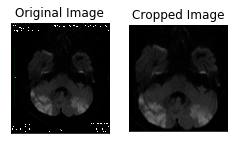

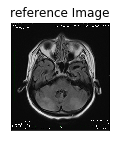

In [56]:
ex_img = cv2.imread('CLEANED_DATA_1/Bilateral cerebellar hemispheres/DWI.jpg')
ex_img_ref = cv2.imread('CLEANED_DATA_1/Bilateral cerebellar hemispheres/FLAIR.jpg')
ex_new_img = crop_brain_contour(ex_img,ex_img_ref, True)

# DATA AUGMENTATION

In [57]:
def augment_dataset(dir_list):
    """
    Arguments:
        file_dir: A string representing the directory where files containg images that we want to augment are found.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=7, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1,
                                  brightness_range=(0.001, 0.9),
                                  horizontal_flip=False, 
                                  vertical_flip=False, 
                                  fill_mode='nearest'
                                 )
    try:
        os.mkdir('AUGMENTED_DATA_1')
    except:
        print("AUGMENTED_DATA_1 is already created")
        
    for directory in listdir(dir_list):
        save_to_dir="AUGMENTED_DATA_1/"+ directory
        try:
            os.mkdir(save_to_dir)
        except:
            print(save_to_dir+"is already created")
        filename="DWI.jpg"
        # load the image
        image = cv2.imread(dir_list + '\\'+directory + '\\' + "DWI.jpg")
            
        imageref = cv2.imread("CLEANED_DATA_1" + '\\'+directory + '\\' + "FLAIR.jpg")
        # crop the brain and ignore the unnecessary rest part of the image
        image = crop_brain_contour(image,imageref, plot=False)
        
        image = image.reshape((1,) + image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
            
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix,
                                       save_format='jpg'):
                i += 1
                if i > 20:
                    break
    return 0

# uncomment if augmented_data not present

In [58]:
#augment_dataset("CLEANED_DATA_1")

# LOAD THE DATA

In [59]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    target_names={}
    i=0
    for directory in os.listdir(dir_list):
        target_names[i]=directory
        for filename in os.listdir(dir_list+'\\'+directory):
            # load the image
            image = cv2.imread(dir_list + '\\'+directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            #image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            y.append(i)
        i=i+1
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    return X, y,target_names

Load up the data that we augmented earlier in the Data Augmentation function.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [60]:
X,y,target_names = load_data("AUGMENTED_DATA_1",[32,32])

Number of examples is: 965
X shape is: (965, 32, 32, 3)
y shape is: (965,)


In [61]:
target_names.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

# PLOT SAMPLES

In [62]:
def plot_sample_images(X, y,target_names,n=10):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
        target_names: Dictonary with key value is no assigned to respective brain region.
    """
    
    for label in target_names.keys():
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 1))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            plt.xticks([])
            plt.yticks([])
            i += 1
        
        label_to_str = lambda label: target_names[label]
        plt.suptitle(f"Brain inffract: {label_to_str(label)}")
        plt.show()

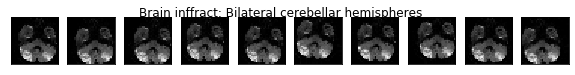

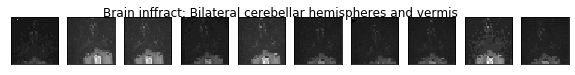

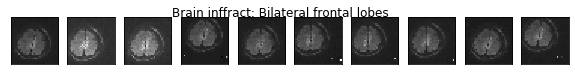

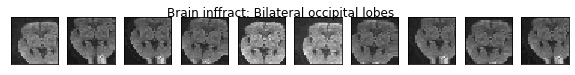

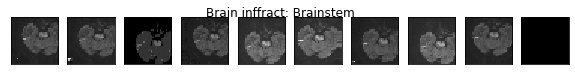

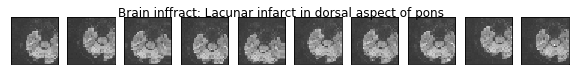

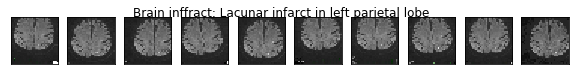

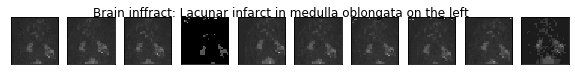

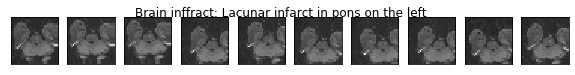

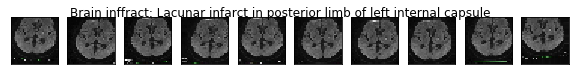

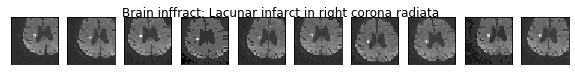

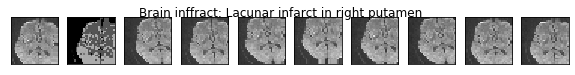

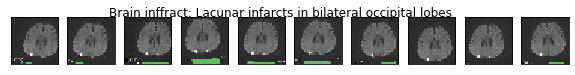

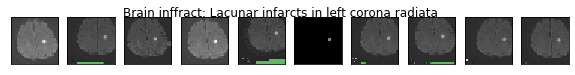

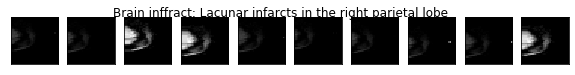

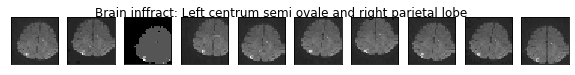

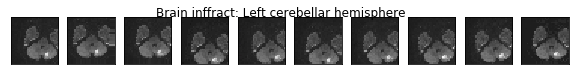

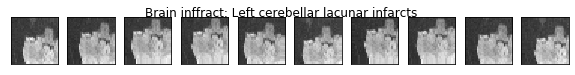

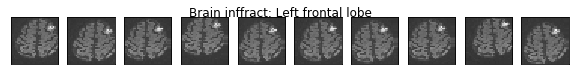

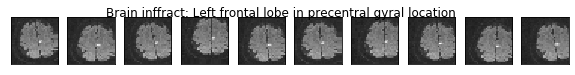

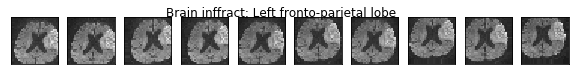

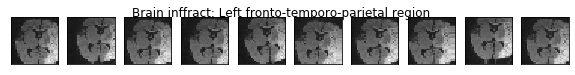

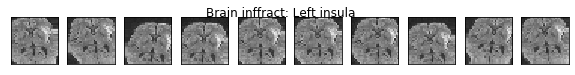

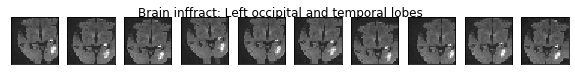

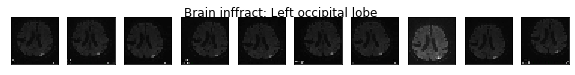

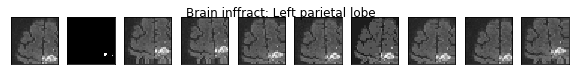

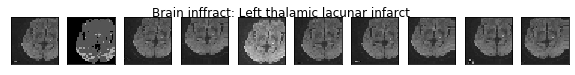

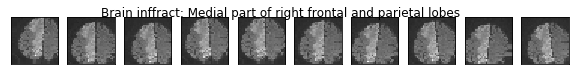

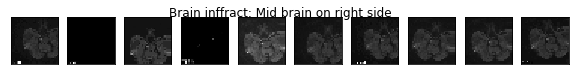

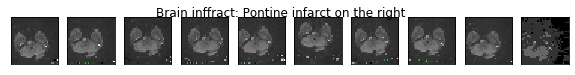

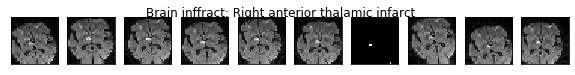

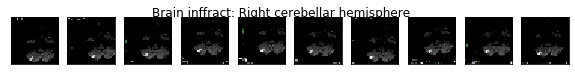

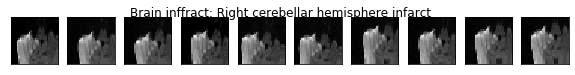

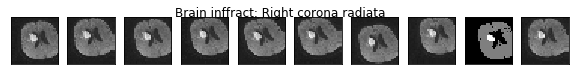

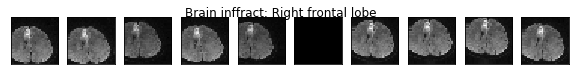

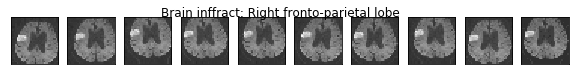

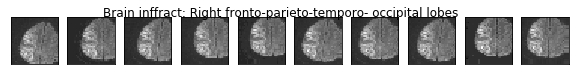

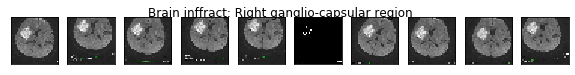

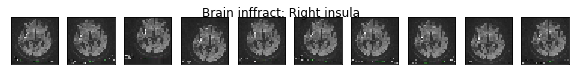

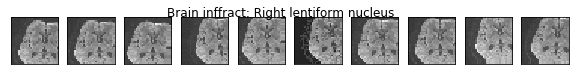

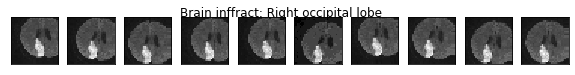

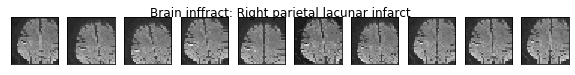

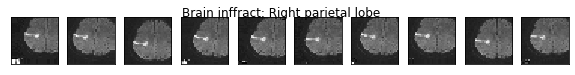

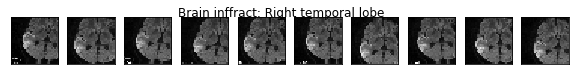

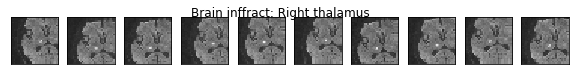

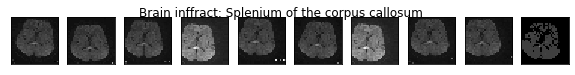

In [64]:
plot_sample_images(X, y,target_names)

# SPLIT THE DATASET

In [65]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print("X_train =",X_train.shape)
print("X_test =",X_test.shape)
print("y_train =",y_train.shape)
print("y_test =",y_test.shape)

X_train = (772, 32, 32, 3)
X_test = (193, 32, 32, 3)
y_train = (772,)
y_test = (193,)


In [66]:
target_names

{0: 'Bilateral cerebellar hemispheres',
 1: 'Bilateral cerebellar hemispheres and vermis',
 2: 'Bilateral frontal lobes',
 3: 'Bilateral occipital lobes',
 4: 'Brainstem',
 5: 'Lacunar infarct in dorsal aspect of pons',
 6: 'Lacunar infarct in left parietal lobe',
 7: 'Lacunar infarct in medulla oblongata on the left',
 8: 'Lacunar infarct in pons on the left',
 9: 'Lacunar infarct in posterior limb of left internal capsule',
 10: 'Lacunar infarct in right corona radiata',
 11: 'Lacunar infarct in right putamen',
 12: 'Lacunar infarcts in bilateral occipital lobes',
 13: 'Lacunar infarcts in left corona radiata',
 14: 'Lacunar infarcts in the right parietal lobe',
 15: 'Left centrum semi ovale and right parietal lobe',
 16: 'Left cerebellar hemisphere',
 17: 'Left cerebellar lacunar infarcts',
 18: 'Left frontal lobe',
 19: 'Left frontal lobe in precentral gyral location',
 20: 'Left fronto-parietal lobe',
 21: 'Left fronto-temporo-parietal region',
 22: 'Left insula',
 23: 'Left occip

# BUILDING MODEL 

In [67]:
IMG_WIDTH, IMG_HEIGHT = (32, 32)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
NUM_CLASSES = 46

In [68]:
def build_model(input_shape,num_classes=46):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
        num_classes: number of output neurons
    Returns:
        model: A Model object.
    """ 
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(4, 4), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [69]:
model = build_model(IMG_SHAPE,NUM_CLASSES)

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 29, 8)         392       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               58950     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                6946      
Total params: 66,288
Trainable params: 66,288
Non-trainable params: 0
__________________________________________________

### COMPILE THE MODEL

In [71]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test1 = lb.transform(y_test)

In [72]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### CHECKPOINT

In [73]:
#callbacks
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))


### TRAINING THE MODEL

In [74]:
try:
        os.mkdir('models')
except:
        print("models is already created")

In [75]:
model.fit(x=X_train, y=y_train, batch_size=21, epochs=80,validation_split=0.2,callbacks=[checkpoint,es])

Train on 617 samples, validate on 155 samples
Epoch 1/80
617/617 [==============================] - 3s 4ms/sample - loss: 3.8372 - acc: 0.0259 - val_loss: 3.7943 - val_acc: 0.0387
Epoch 2/80
617/617 [==============================] - 1s 2ms/sample - loss: 3.7134 - acc: 0.0778 - val_loss: 3.6993 - val_acc: 0.0839
Epoch 3/80
617/617 [==============================] - 2s 3ms/sample - loss: 3.5630 - acc: 0.1167 - val_loss: 3.4590 - val_acc: 0.2000
Epoch 4/80
617/617 [==============================] - 1s 2ms/sample - loss: 3.3028 - acc: 0.1831 - val_loss: 3.1061 - val_acc: 0.3097
Epoch 5/80
617/617 [==============================] - 1s 2ms/sample - loss: 3.0166 - acc: 0.2156 - val_loss: 2.7043 - val_acc: 0.3290
Epoch 6/80
617/617 [==============================] - 1s 2ms/sample - loss: 2.5841 - acc: 0.3047 - val_loss: 2.2801 - val_acc: 0.5097
Epoch 7/80
617/617 [==============================] - 1s 1ms/sample - loss: 2.3428 - acc: 0.3533 - val_loss: 1.9496 - val_acc: 0.6387
Epoch 8/80
617/6

In [81]:
loss, acc = model.evaluate(x=X_test, y=y_test1)

193/193 [==============================] - 0s 925us/sample - loss: 0.3410 - acc: 0.9171


In [82]:
ymodel=model.predict(X_test)
y_predicted=[]
for i in ymodel:
    y_predicted.append(i.argmax())

In [83]:
accuracy = accuracy_score(y_test, y_predicted)
print('Test Accuracy = %.2f' % accuracy)

Test Accuracy = 0.92


## PLOT OF ACCURACY AND LOSS

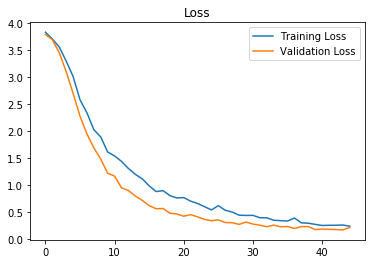

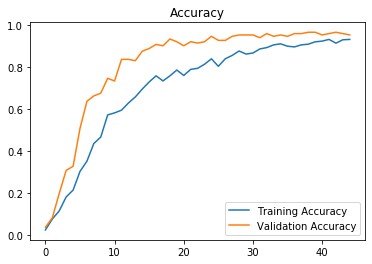

In [84]:
history = model.history.history
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

### Load the best model

In [85]:
best_model = load_model(filepath='models/cnn-parameters-improvement-20-0.92.model')

In [86]:
best_model.metrics_names

['loss', 'acc']

Evaluate the best model on the testing data:

In [87]:
loss, acc = best_model.evaluate(x=X_test, y=y_test1)

193/193 [==============================] - 0s 2ms/sample - loss: 0.6272 - acc: 0.8446


# INFERNCE DATA

## Inference folder should be in same format as cleaned data 

In [88]:
X1,y1,target1 = load_data("inference",[32,32])

r=model.predict(X1)
y_predicted=[]
predicted_names={ }
i=0
for i in range(len(r)):
    print("inf = " ,y1[i])
    print("predicted=",target_names[r[i].argmax()])
    print("target=",target1[y1[i]])
    y_predicted.append(r[i].argmax())
    predicted_names[y1[i]]=(target_names[r[i].argmax()])


Number of examples is: 4
X shape is: (4, 32, 32, 3)
y shape is: (4,)
inf =  3
predicted= Right fronto-parietal lobe
target= 4_right temporal lobe
inf =  1
predicted= Splenium of the corpus callosum
target= 2_Right corona radiata
inf =  2
predicted= Right fronto-parietal lobe
target= 3_Right frontal lobe
inf =  0
predicted= Left parietal lobe
target= 1_Left parietal lobe


# Converting to .pb


    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.

In [33]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
   
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [34]:
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 23 variables.
INFO:tensorflow:Converted 23 variables to const ops.


In [ ]:
tf.train.write_graph(frozen_graph, os.getcwd(), 'pro.pb', as_text=False)

## Loading .pb file

In [36]:
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    f = gfile.FastGFile(str(os.getcwd())+'\\'+'pro.pb', 'rb')
    graph_def = tf.GraphDef()
    # Parses a serialized binary message into the current message.
    graph_def.ParseFromString(f.read())
    f.close()

    sess.graph.as_default()
    # Import a serialized TensorFlow `GraphDef` protocol buffer
    # and place into the current default `Graph`.
    g_in = tf.import_graph_def(graph_def)

Instructions for updating:
Use tf.gfile.GFile.


In [37]:
writer = tf.summary.FileWriter(str(os.getcwd())+'\log')
writer.add_graph(sess.graph)
writer.flush()
writer.close()